In [102]:
import numpy as np
import os
import tensorflow as tf
import cv2
import json
import matplotlib.pyplot as plt
import pandas as pd

print("Hello world.")

Hello world.


In [103]:
import os
import json
import numpy as np
import cv2

def create_mask(json_file, image_shape):
    if json_file is None or not os.path.exists(json_file):
        return None
    try:
        with open(json_file, 'r') as f:
            data = json.load(f)
    except:
        return None
    if 'shapes' not in data or data['shapes'] is None:
        return None

    mask = np.zeros(image_shape[:2], dtype=np.uint8)

    try:
        for shape in data['shapes']:
            points = np.array(shape.get('points', []), dtype=np.int32)
            if len(points) > 2:
                cv2.fillPoly(mask, [points], 255)
    except:
        return None

    return mask


def find_image_file(base_name, image_path):
    """Find the correct image file (.jpg, .JPG, .jpeg, .JPEG, .png)"""
    exts = [".jpg", ".JPG", ".jpeg", ".JPEG", ".png"]
    for ext in exts:
        file_path = os.path.join(image_path, base_name + ext)
        if os.path.exists(file_path):
            return file_path
    return None

print("Hello world")

Hello world


In [104]:
train_images, valid_images, test_images  = [], [], []
train_masks, valid_masks, test_masks = [], [] , []
test_images_a, test_images_b, test_images_d = [], [], []
test_masks_a, test_masks_b, test_masks_d = [], [], []

image_path = "/kaggle/input/malabar-dataset/Malabar_Dataset_Original_Data/Malabar_Dataset/Anthracnose(102)"
json_path = "/kaggle/input/annotated-dataset-json-files-version-2/annotated_json_files/Anthracnose(102)/affected_region"
split_file = pd.read_csv("/kaggle/input/malabar-dataset/anthracnose_split.csv")


for i in range(0, len(split_file)):
    used_for = split_file.iloc[i]["used_for"]
    image_no = split_file.iloc[i]["image_no"]
    base_name = f"Anthracnose ({image_no})"

    json_file = os.path.join(json_path, base_name + ".json")

    # --- FIND REAL IMAGE FILE ---
    image_file = find_image_file(base_name, image_path)
    if image_file is None:
        print(f"Image missing: {base_name}")
        continue

    image = cv2.imread(image_file)
    if image is None:
        print(f"Failed to read: {image_file}")
        continue

    mask = create_mask(json_file, image.shape)
    if mask is None:
        print(f"Mask skipped: {json_file}")
        continue

    if used_for == "training":
        train_images.append(image)
        train_masks.append(mask)
    elif used_for == "validation":
        valid_images.append(image)
        valid_masks.append(mask)
    else:
        test_images.append(image)
        test_masks.append(mask)
        test_images_a.append(image)
        test_masks_a.append(mask)



print(len(train_images), len(train_masks))
print(len(valid_images), len(valid_masks))
print(len(test_images), len(test_masks))

80 80
10 10
12 12


In [105]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np

# Preprocess images and masks
image_size = (256, 256)

def preprocess_data(images, masks):
    images_resized = [cv2.resize(img, image_size) for img in images]
    masks_resized = [cv2.resize(mask, image_size) for mask in masks]
    
    images_array = np.array(images_resized) / 255.0
    masks_array = np.array(masks_resized) / 255.0
    
    images_array = images_array.astype(np.float32)
    masks_array = masks_array.astype(np.float32)
    
    masks_array = np.expand_dims(masks_array, axis=-1)  # Ensure correct shape
    
    return images_array, masks_array


X_test, Y_test = preprocess_data(test_images, test_masks)
print("Hello world.")

Hello world.


In [106]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

# Prediction and Mask Creation
def create_mask(predictions):
    # Convert predictions to binary mask
    predictions = (predictions > 0.5).astype(np.uint8)
    return predictions

# Load model and predict
best_model = load_model("/kaggle/input/temp-testing-dataset/Unet_plus_plus_semi_final_best_model.keras")
predictions = best_model.predict(X_test)

# Create masks from predictions
predicted_masks = create_mask(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 40s 40s/step


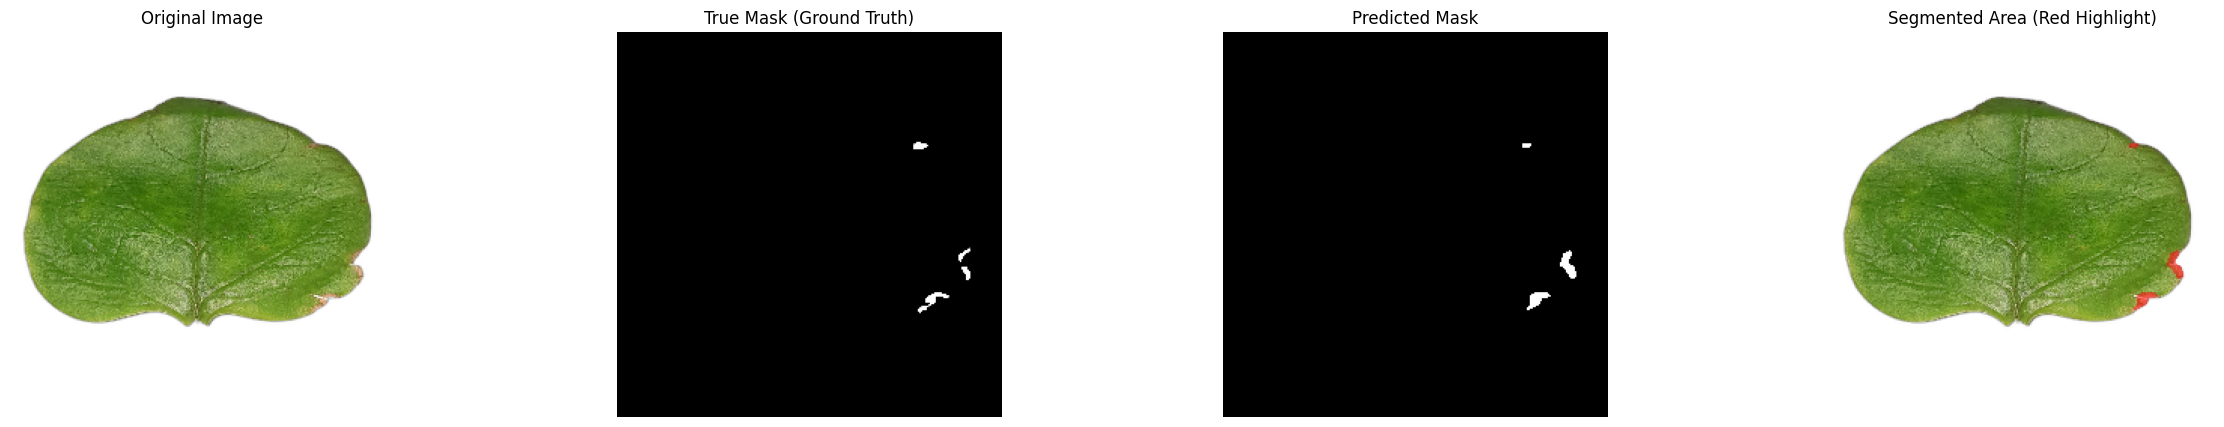

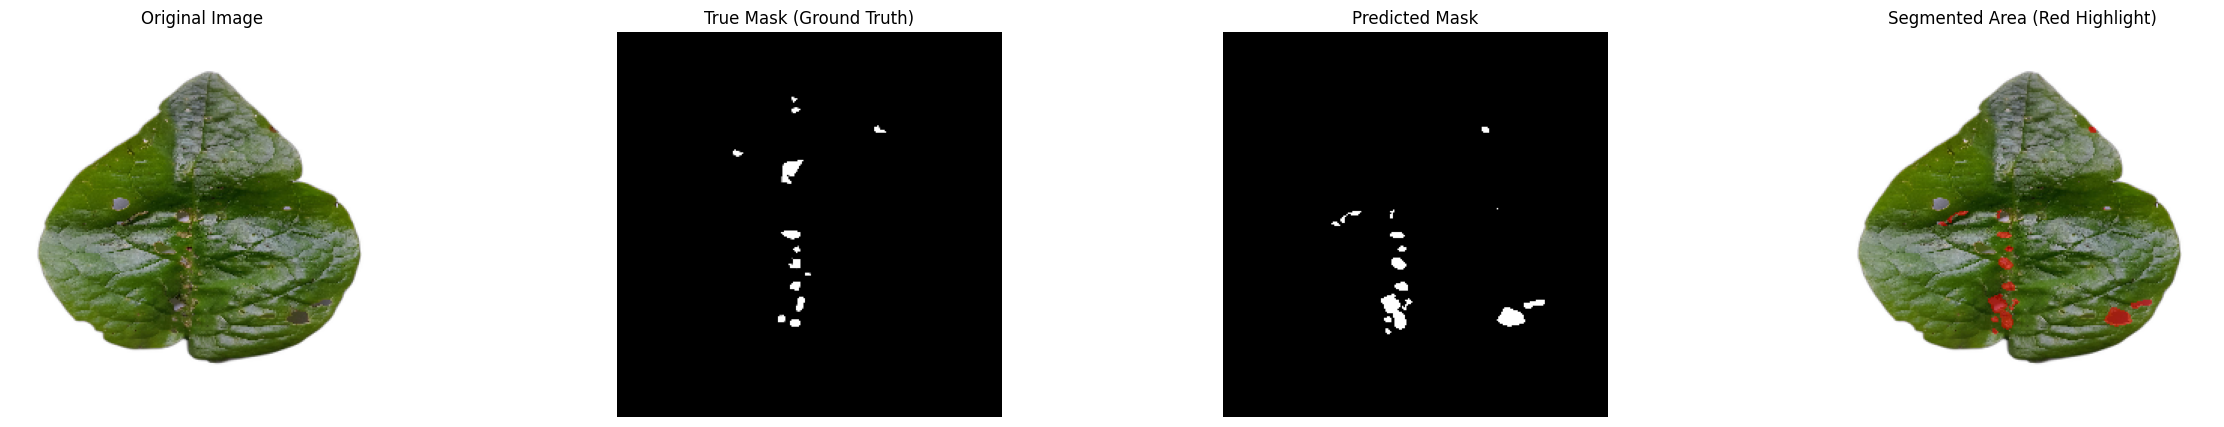

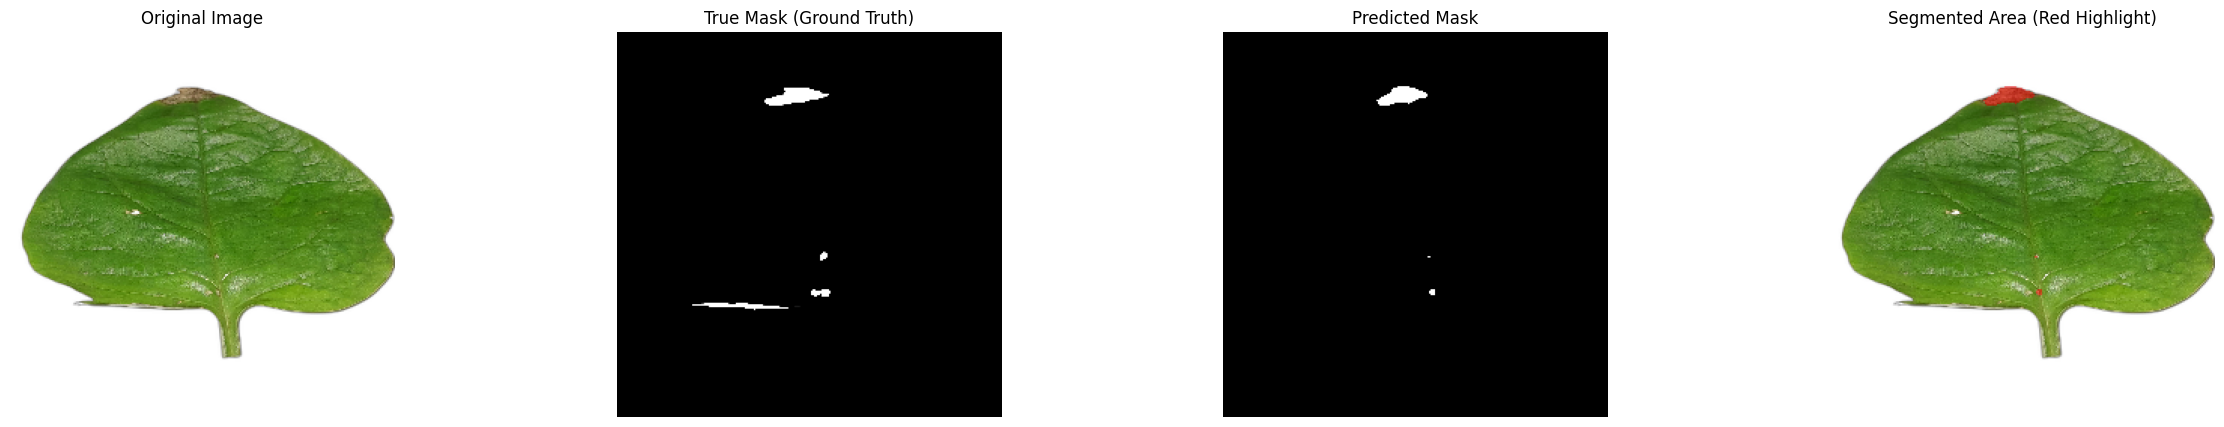

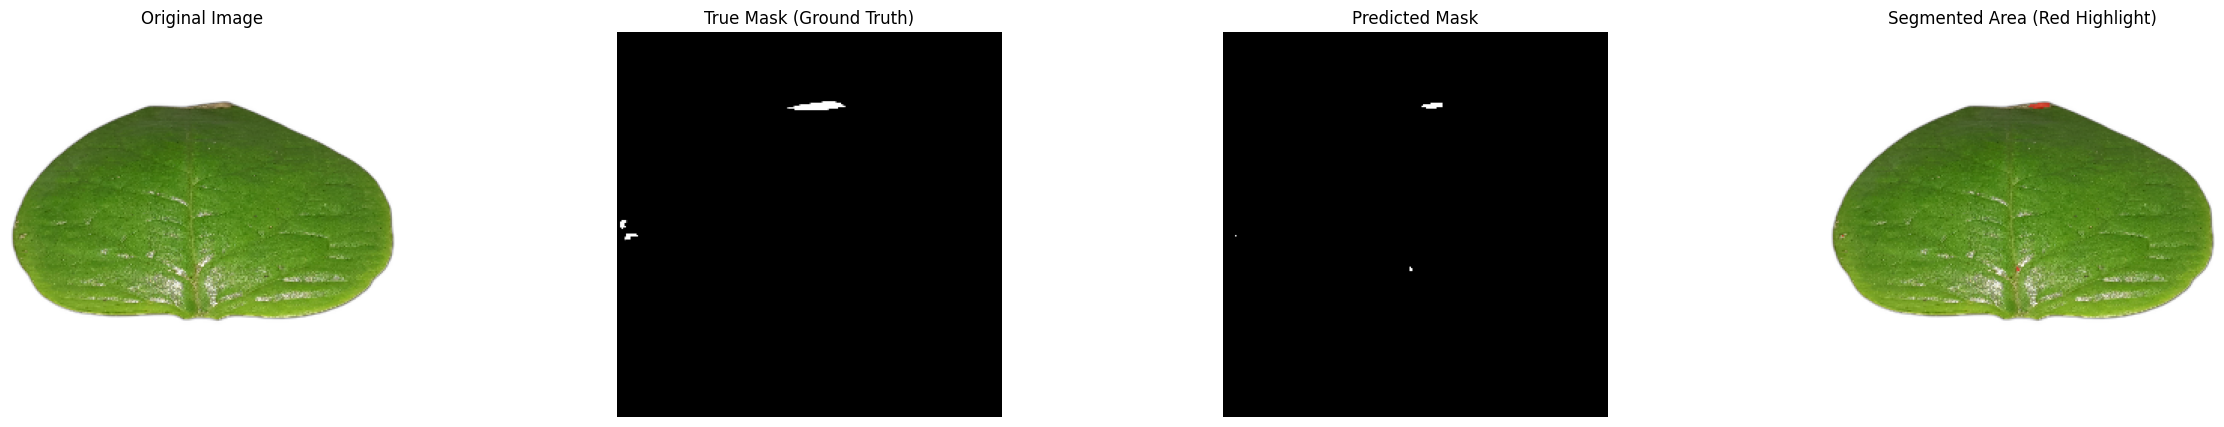

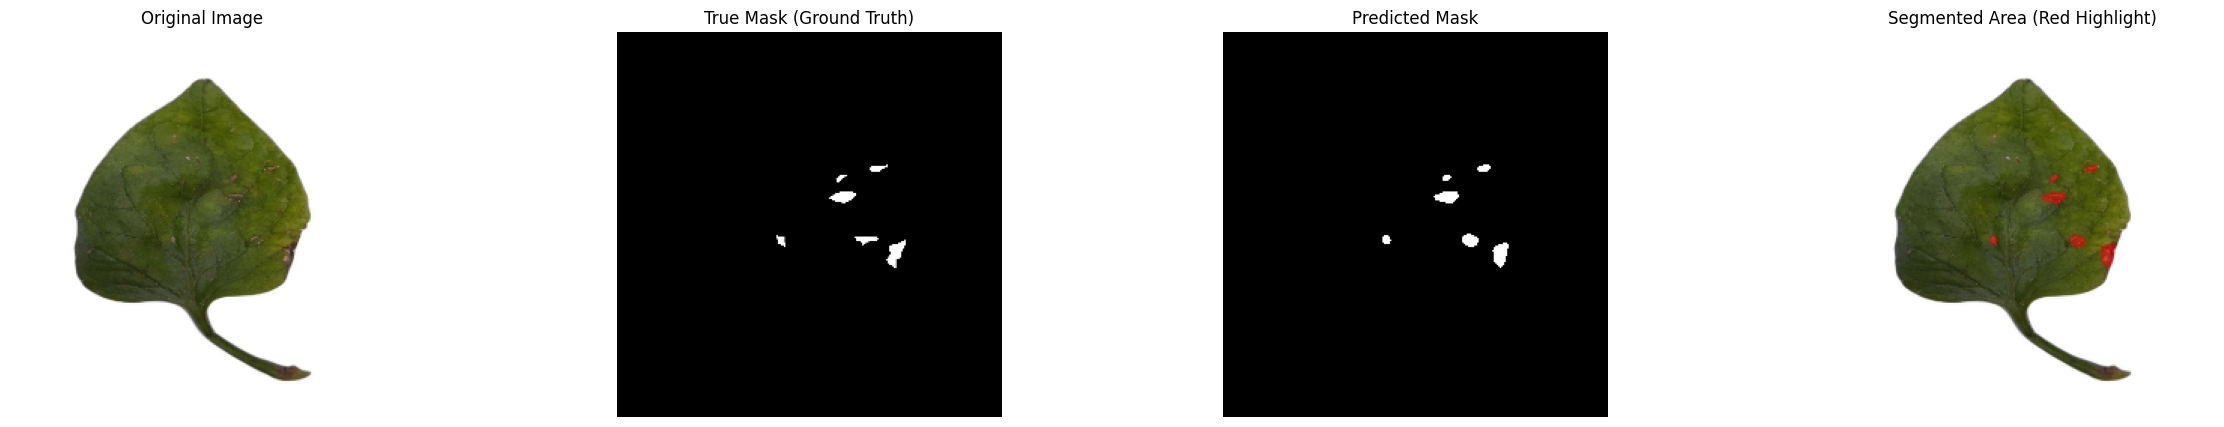

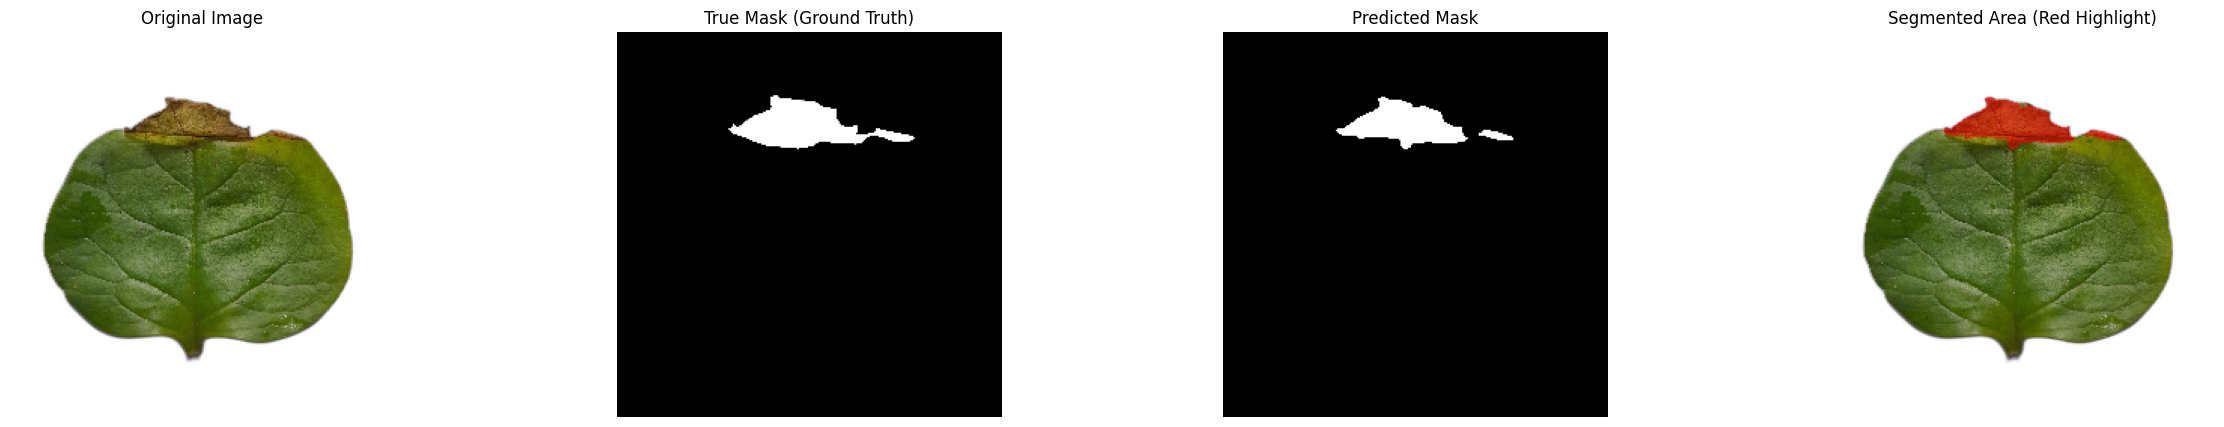

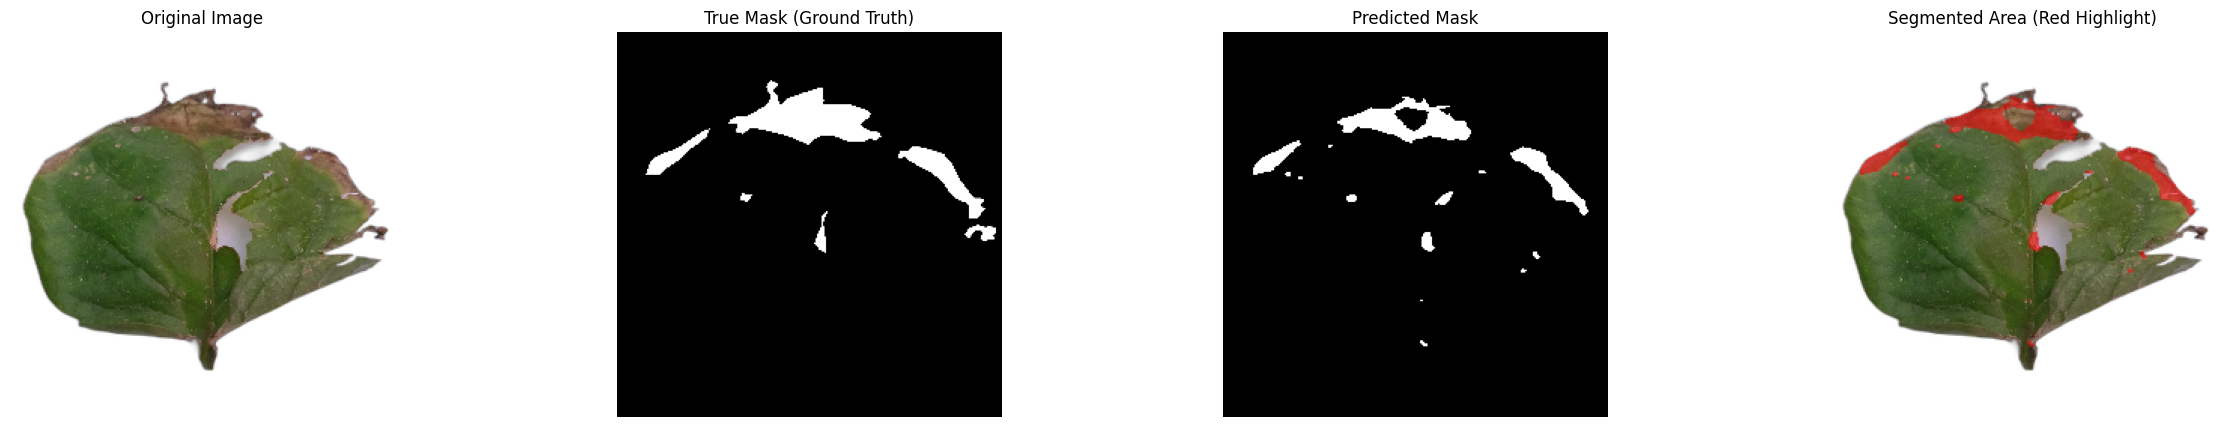

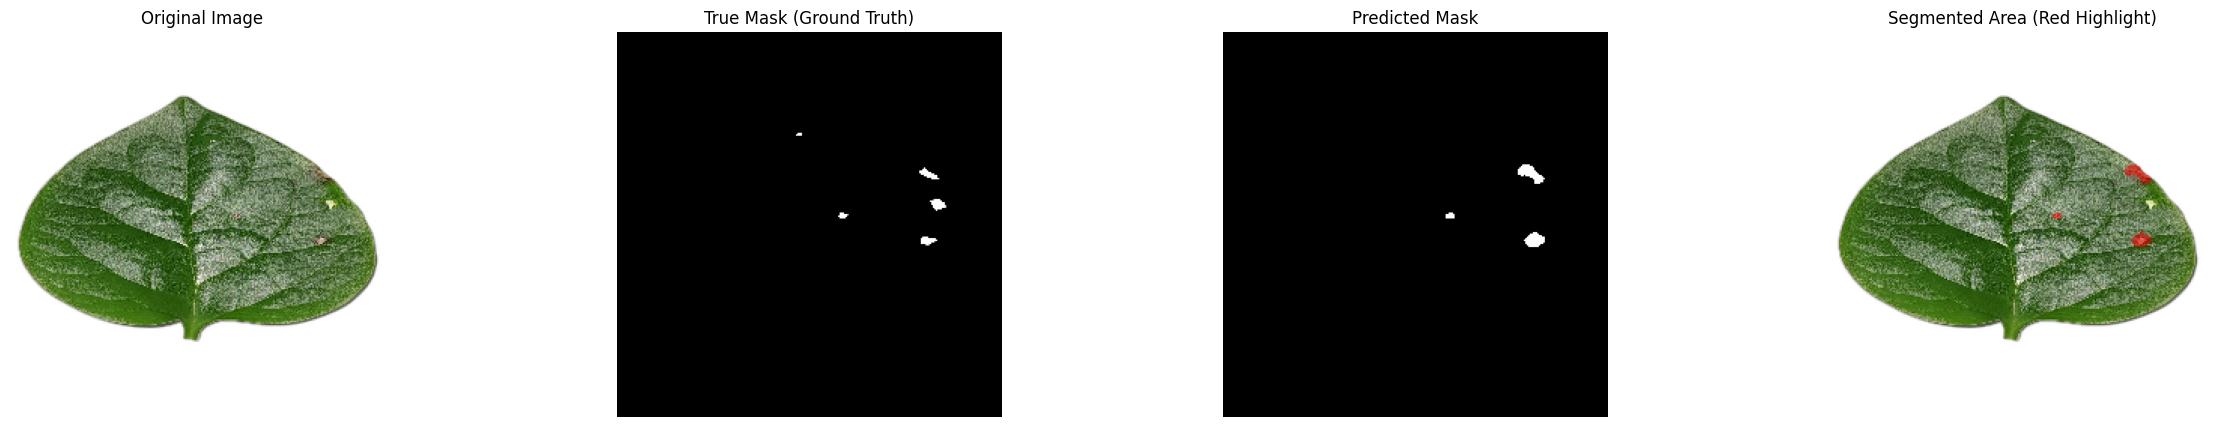

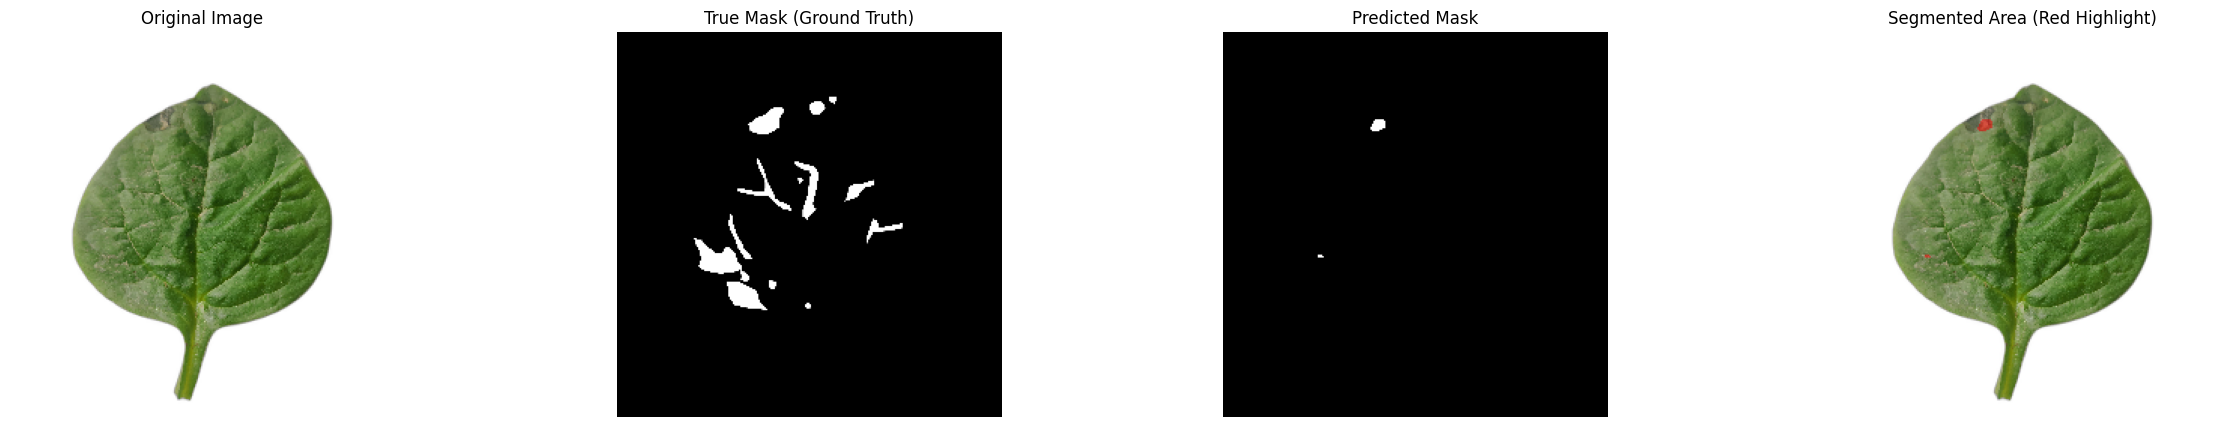

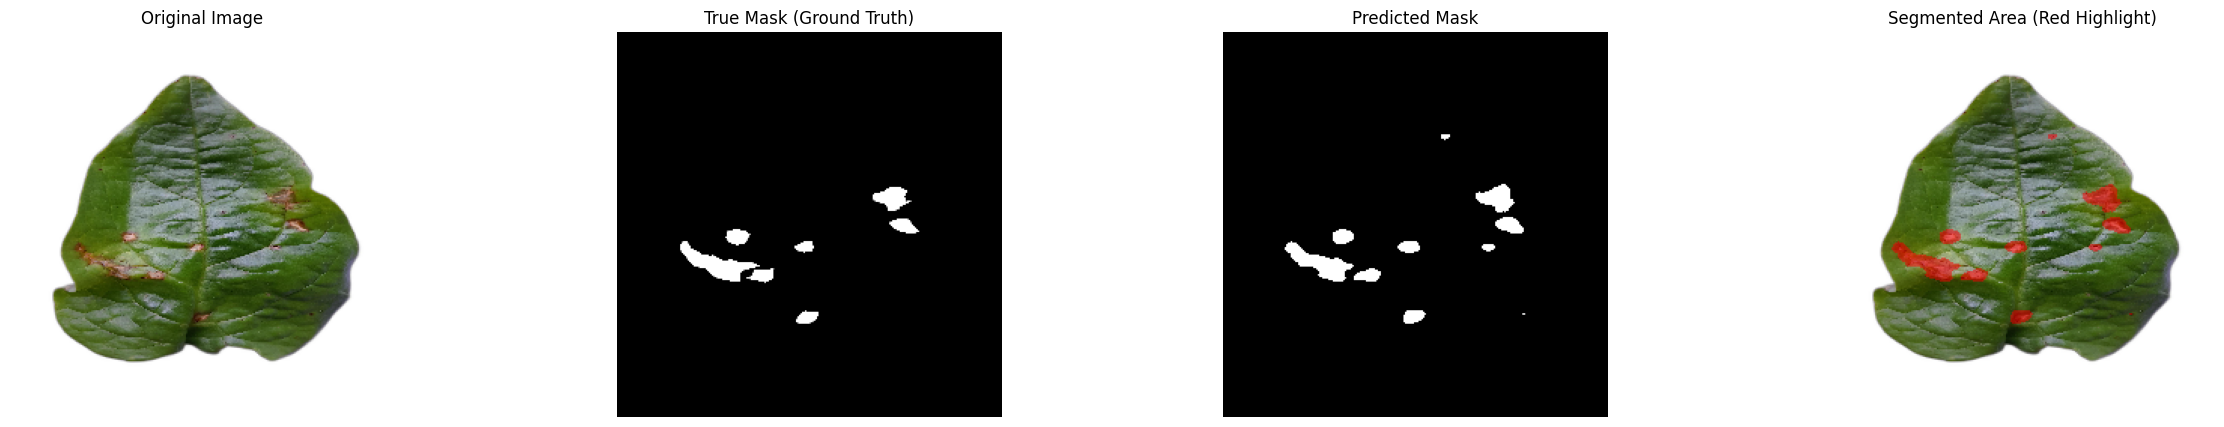

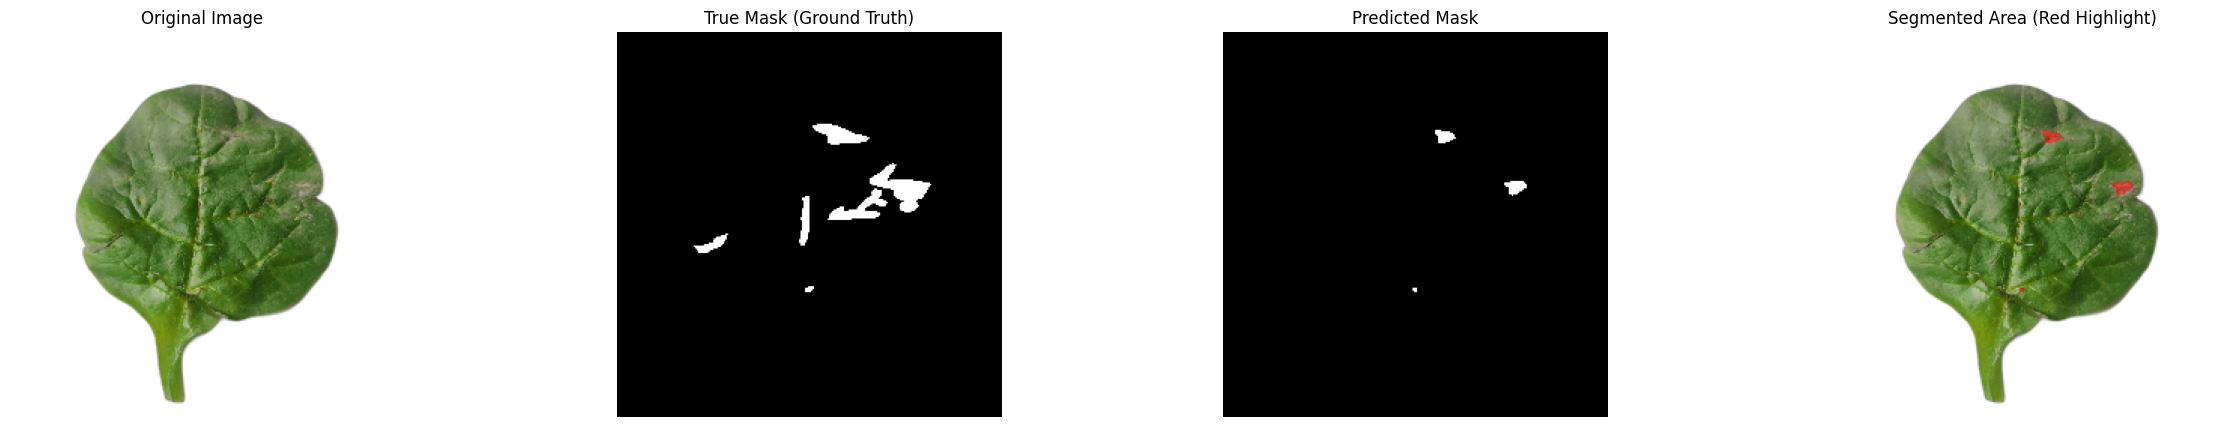

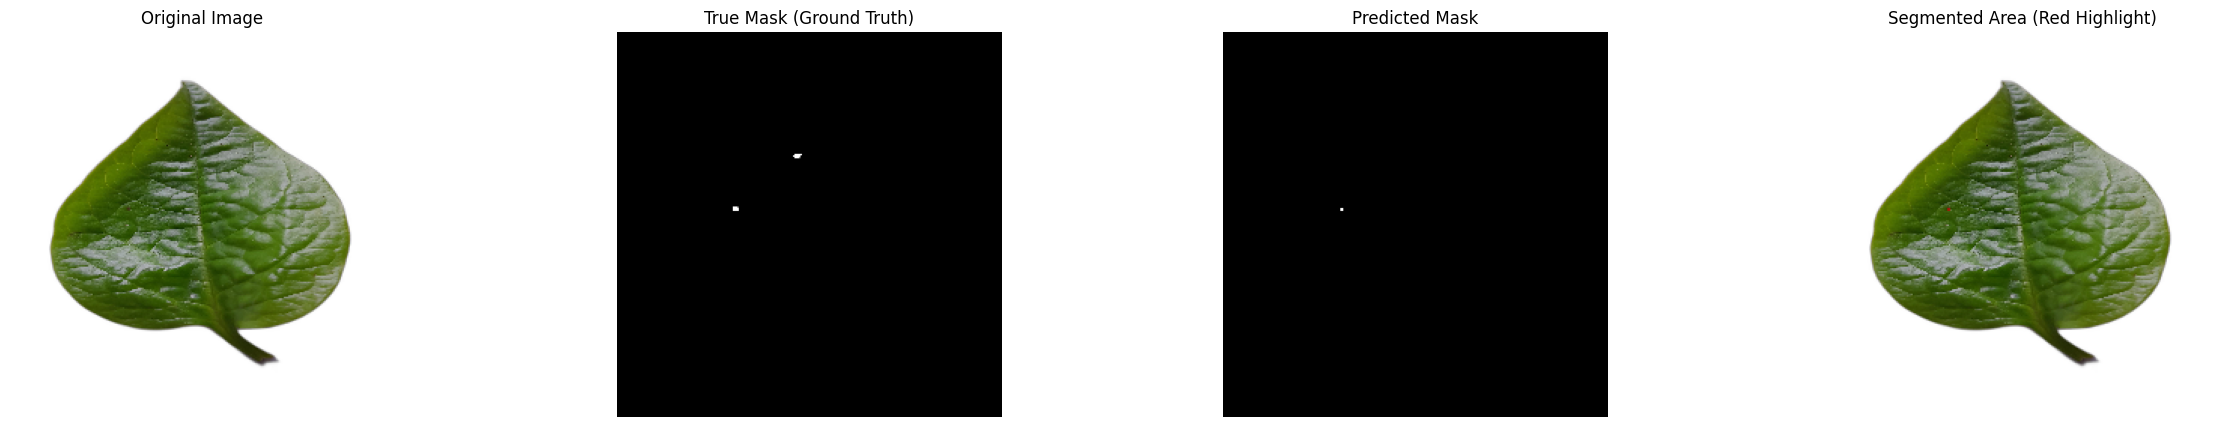

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def visualize_results(images, y_test, predicted_masks):
    for i in range(len(images)):
        img = images[i]
        true_mask = y_test[i].squeeze()
        predicted_mask = predicted_masks[i].squeeze()

        # Binary predicted mask
        pred_bin = (predicted_mask > 0.5).astype(np.uint8)

        # Ensure uint8 image
        img_uint8 = (img * 255).astype(np.uint8) if img.dtype != np.uint8 else img

        # ---- Red Highlight using Predicted Mask ----
        output = img_uint8.copy()
        alpha = 0.5
        red_color = np.array([0, 0, 255])  # BGR red

        output[pred_bin == 1] = (
            img_uint8[pred_bin == 1] * (1 - alpha) + red_color * alpha
        ).astype(np.uint8)

        # ---- Visualization ----
        plt.figure(figsize=(30, 5))

        plt.subplot(1, 4, 1)
        plt.imshow(cv2.cvtColor(img_uint8, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.imshow(true_mask, cmap='gray')
        plt.title('True Mask (Ground Truth)')
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.imshow(predicted_mask, cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
        plt.title('Segmented Area (Red Highlight)')
        plt.axis('off')

        plt.show()

visualize_results(X_test, Y_test, predicted_masks)

In [108]:
import os
import cv2
import numpy as np
import zipfile
from scipy import stats
from skimage.segmentation import find_boundaries

# ===============================
# Paths
# ===============================
BASE_DIR = "/kaggle/working/segmentation_results"

dirs = {
    "original": os.path.join(BASE_DIR, "original_images"),
    "true": os.path.join(BASE_DIR, "true_masks"),
    "pred": os.path.join(BASE_DIR, "predicted_masks"),
    "red": os.path.join(BASE_DIR, "red_highlighted")
}

for d in dirs.values():
    os.makedirs(d, exist_ok=True)

# ===============================
# Save images
# ===============================
alpha = 0.5
red_color = np.array([0, 0, 255])  # BGR

for i in range(len(X_test)):
    # ---- Original Image ----
    img = X_test[i]
    img_uint8 = (img * 255).astype(np.uint8) if img.dtype != np.uint8 else img
    cv2.imwrite(f"{dirs['original']}/original_image_{i+1}.jpg", img_uint8)

    # ---- True Mask ----
    true_mask = Y_test[i].squeeze()
    true_mask_uint8 = (true_mask * 255).astype(np.uint8)
    cv2.imwrite(f"{dirs['true']}/true_mask_{i+1}.png", true_mask_uint8)

    # ---- Predicted Mask ----
    pred_mask = (predicted_masks[i].squeeze() > 0.5).astype(np.uint8)
    pred_mask_uint8 = pred_mask * 255
    cv2.imwrite(f"{dirs['pred']}/predicted_mask_{i+1}.png", pred_mask_uint8)

    # ---- Red Highlighted Segmentation ----
    output = img_uint8.copy()
    output[pred_mask == 1] = (
        img_uint8[pred_mask == 1] * (1 - alpha) + red_color * alpha
    ).astype(np.uint8)

    cv2.imwrite(f"{dirs['red']}/red_highlight_{i+1}.jpg", output)

# ===============================
# Zip folders
# ===============================
def zip_folder(folder_path, zip_name):
    zip_path = os.path.join(BASE_DIR, zip_name)
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(folder_path):
            for file in files:
                full_path = os.path.join(root, file)
                zipf.write(full_path, arcname=file)

zip_folder(dirs['original'], "original_image.zip")
zip_folder(dirs['true'], "true_mask.zip")
zip_folder(dirs['pred'], "predicted_mask.zip")
zip_folder(dirs['red'], "red_highligh_segmented_area.zip")

print("✅ All ZIP files created successfully!")


✅ All ZIP files created successfully!


In [109]:
def preprocess_masks(gt, pred, threshold=0.5):
    gt = gt.squeeze()
    pred = pred.squeeze()

    gt_bin = (gt > 0).astype(np.uint8)
    pred_bin = (pred > threshold).astype(np.uint8)

    return gt_bin, pred_bin


In [110]:
def dice_coefficient(gt, pred, eps=1e-7):
    intersection = np.sum(gt * pred)
    return (2. * intersection) / (np.sum(gt) + np.sum(pred) + eps)

def iou_score(gt, pred, eps=1e-7):
    intersection = np.sum(gt * pred)
    union = np.sum(gt) + np.sum(pred) - intersection
    return intersection / (union + eps)

def precision_score(gt, pred, eps=1e-7):
    tp = np.sum(gt * pred)
    fp = np.sum((1 - gt) * pred)
    return tp / (tp + fp + eps)

def recall_score(gt, pred, eps=1e-7):
    tp = np.sum(gt * pred)
    fn = np.sum(gt * (1 - pred))
    return tp / (tp + fn + eps)


In [111]:
def boundary_f1_score(gt, pred, eps=1e-7):
    gt_boundary = find_boundaries(gt, mode='inner')
    pred_boundary = find_boundaries(pred, mode='inner')

    tp = np.sum(gt_boundary & pred_boundary)
    fp = np.sum(pred_boundary & ~gt_boundary)
    fn = np.sum(gt_boundary & ~pred_boundary)

    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)

    return 2 * precision * recall / (precision + recall + eps)


In [112]:
def area_metrics(gt, pred, eps=1e-7):
    gt_area = np.sum(gt)
    pred_area = np.sum(pred)

    ratio = pred_area / (gt_area + eps)
    relative_diff = ((pred_area - gt_area) / (gt_area + eps)) * 100

    return ratio, relative_diff


In [113]:
results = []

for i in range(len(Y_test)):
    gt, pred = preprocess_masks(Y_test[i], predicted_masks[i])

    dice = dice_coefficient(gt, pred)
    iou = iou_score(gt, pred)
    precision = precision_score(gt, pred)
    recall = recall_score(gt, pred)
    bf1 = boundary_f1_score(gt, pred)

    ratio, rel_diff = area_metrics(gt, pred)

    results.append([
        dice, iou, precision, recall, bf1, ratio, rel_diff
    ])


/tmp/ipykernel_55/2373250192.py:6: RuntimeWarning: overflow encountered in scalar subtract
  relative_diff = ((pred_area - gt_area) / (gt_area + eps)) * 100


In [114]:
columns = [
    "Dice",
    "IoU",
    "Precision",
    "Recall",
    "Boundary_F1",
    "Area_Ratio_Pred_GT",
    "Relative_Area_Difference_%"
]

df = pd.DataFrame(results, columns=columns)
df


,Dice,IoU,Precision,Recall,Boundary_F1,Area_Ratio_Pred_GT,Relative_Area_Difference_%
0,0.658416,0.490775,0.610092,0.715054,0.257143,1.172043,1.720430e+01
1,0.332458,0.199370,0.276163,0.417582,0.182156,1.512088,5.120879e+01
2,0.660976,0.493625,0.960993,0.503717,0.265060,0.524164,3.428763e+18
3,0.349593,0.211823,0.895833,0.217172,0.014084,0.242424,9.316537e+18
4,0.819407,0.694064,0.806366,0.832877,0.421725,1.032877,3.287671e+00
5,0.895418,0.810639,0.992827,0.815415,0.291339,0.821306,9.055839e+17
6,0.744706,0.593253,0.921210,0.624964,0.235974,0.678417,5.329888e+17
7,0.518160,0.349673,0.449580,0.611429,0.134078,1.360000,3.600000e+01
8,0.070779,0.036688,1.000000,0.036688,0.022504,0.036688,9.668105e+17
9,0.879593,0.785065,0.852008,0.909023,0.403248,1.066917,6.691729e+00


In [115]:
df.to_csv("/kaggle/working/segmentation_metrics.csv", index=False)


In [116]:
t_stat, p_ttest = stats.ttest_1samp(df["Relative_Area_Difference_%"], 0)
print("Paired t-test p-value:", p_ttest)


Paired t-test p-value: 0.23839389234233926


In [117]:
w_stat, p_wilcoxon = stats.wilcoxon(df["Relative_Area_Difference_%"])
print("Wilcoxon test p-value:", p_wilcoxon)


Wilcoxon test p-value: 0.00048828125


In [118]:
summary = df.agg(['mean', 'std'])
summary


,Dice,IoU,Precision,Recall,Boundary_F1,Area_Ratio_Pred_GT,Relative_Area_Difference_%
mean,0.535301,0.412261,0.813756,0.497173,0.200862,0.727423,7.279335e+18
std,0.279999,0.269768,0.241344,0.303197,0.138580,0.511228,2.022613e+19


In [119]:
overall_mean = df.mean()
overall_std  = df.std()

overall_results = pd.DataFrame({
    "Mean": overall_mean,
    "Std": overall_std
})

overall_results


,Mean,Std
Dice,5.353008e-01,2.799986e-01
IoU,4.122609e-01,2.697677e-01
Precision,8.137560e-01,2.413440e-01
Recall,4.971729e-01,3.031967e-01
Boundary_F1,2.008619e-01,1.385801e-01
Area_Ratio_Pred_GT,7.274232e-01,5.112280e-01
Relative_Area_Difference_%,7.279335e+18,2.022613e+19


In [120]:
gt_all = []
pred_all = []

for i in range(len(Y_test)):
    gt, pred = preprocess_masks(Y_test[i], predicted_masks[i])
    gt_all.append(gt.flatten())
    pred_all.append(pred.flatten())

gt_all = np.concatenate(gt_all)
pred_all = np.concatenate(pred_all)


In [121]:
global_dice = dice_coefficient(gt_all, pred_all)
global_iou = iou_score(gt_all, pred_all)
global_precision = precision_score(gt_all, pred_all)
global_recall = recall_score(gt_all, pred_all)

global_dice, global_iou, global_precision, global_recall


(np.float64(0.6438648127441192),
 np.float64(0.47477922466341277),
 np.float64(0.8398199629224276),
 np.float64(0.5220539828791799))

In [123]:
from skimage import segmentation
from sklearn.metrics import f1_score

def global_boundary_f1(gt_masks, pred_masks, boundary_thickness=1):
    """
    Computes global Boundary F1 score.
    """
    gt_bound_all = []
    pred_bound_all = []
    
    for gt, pred in zip(gt_masks, pred_masks):
        # Ensure binary
        gt_bin = (gt > 0.5).astype(np.uint8)
        pred_bin = (pred > 0.5).astype(np.uint8)
        
        # Extract boundaries using morphological gradient
        gt_bound = segmentation.find_boundaries(gt_bin, mode='thick').astype(np.uint8)
        pred_bound = segmentation.find_boundaries(pred_bin, mode='thick').astype(np.uint8)
        
        # Flatten and collect
        gt_bound_all.append(gt_bound.flatten())
        pred_bound_all.append(pred_bound.flatten())
    
    # Concatenate all boundaries (global)
    gt_all = np.concatenate(gt_bound_all)
    pred_all = np.concatenate(pred_bound_all)
    
    # Compute F1 score
    bf_global = f1_score(gt_all, pred_all)
    return bf_global

# Example usage
global_bf = global_boundary_f1(Y_test, predicted_masks)
print(f"Global Boundary F1 Score: {global_bf:.4f}")

Global Boundary F1 Score: 0.3439


In [126]:
ar = np.sum(pred_all) / (np.sum(gt_all) + 1e-7)
print(ar)
"""
mean_area_ratio = df["Area_Ratio_Pred_GT"].mean()
std_area_ratio = df["Area_Ratio_Pred_GT"].std()

"""

print("Hellow world")

0.6216260697776363
Hellow world


In [127]:
mean_relative_diff = df["Relative_Area_Difference_%"].mean()


In [128]:
print("Hello world.")
while(True):
    a = 5

Hello world.


KeyboardInterrupt: 